In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Initial required libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Loading the Dataset
*About the data:* <br>
The data is an twitter comments of various US Airlines having sentiments of the tweet: positive, negative or neutral.

*Columns:* <br>


1.   text: The actual tweet
2.   airline: Name of the airline tweeted about
3. latitude, longitude: Location of the tweet
4. airline_sentiment_confidence : Confidence of the sentiment classification of the tweet
5. airline_sentiment: Sentiment of the tweet


In [3]:
#intializing global variables
data = pd.read_csv('https://raw.githubusercontent.com/anjaliasha123/Data_Visualization_projects/master/Streamlit_python/Tweets.csv')
print(data.text.head(2))
print(data.airline_sentiment.head(2))
data['LABEL'] = 0
data.loc[data.airline_sentiment == 'positive', 'LABEL'] = 0
data.loc[data.airline_sentiment == 'negative', 'LABEL'] = 1
data.loc[data.airline_sentiment == 'neutral', 'LABEL'] = 2
print(data['LABEL'][:10])

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
Name: text, dtype: object
0     neutral
1    positive
Name: airline_sentiment, dtype: object
0    2
1    0
2    2
3    1
4    1
5    1
6    0
7    2
8    0
9    0
Name: LABEL, dtype: int64


In [4]:
dataCopy = data

For the purpose of this project, we are considering only the 'text' column of the Xdata

#MOST COMMON VARIABLES:


*   most_common : for the most common words of the dictionary
*   max_len :
* epochs : Number of times the training of the model must be done. It is a value that determines when a model should stop its training explicitly.
* embed_dim : Dimension of a word vector
* batch_size : size of a batch to train during each itteration of model training


In [5]:
most_common = 20000 #number of vocabs to be considered for the embedding matrix
max_len = 100 
epochs = 10
embed_dim = 100
batch_size = 100

#Data Preprocessing



*   We need to convert y labels into categorical values
*   We need to convert the 



In [6]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(data['LABEL'], num_classes=3)
print(labels[:10])

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from utilsfunction import dataPreprocessing

pX, size_unique_wordsX, wordIndex = dataPreprocessing(most_common,data)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found 15768 unique tokens.


#Train-test split
* 80% train data and 20 % test data



In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pX , labels, test_size=0.2, random_state=42)

In [10]:
print('Training shape X: {} y:{}'.format(X_train.shape, y_train.shape))
print('Testing shape X: {} y:{}'.format(X_test.shape, y_test.shape))

Training shape X: (11712, 100) y:(11712, 3)
Testing shape X: (2928, 100) y:(2928, 3)


#Creating the WordToVector dictionary

In [11]:
from utilsfunction import createEmbeddingMatrix

embedMatrix, num_of_words = createEmbeddingMatrix(wordIndex)

In [12]:
embedMatrix.shape

(15769, 100)

#Creating the Model

In [29]:
def attentionLayer(hidden_vectors,cnn_vector):
  hidden_size = int(hidden_vectors.shape[2])
  preActivation = Dense(hidden_size, use_bias=False, activation= "tanh")(cnn_vector)
  h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_vectors)
  score = dot([cnn_vector,h_t], [2, 1])
  alphas = Activation('softmax')(score)
  contextVector = Dot(axes=[1, 1], name='context_vector')([cnn_vector, alphas])
  return contextVector


In [30]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, dot
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.callbacks import Callback
import tensorflow
def createModel(num_of_words, max_len, embedMatrix, lstm_units, num_classes):
  #creating the embedding layer
  embedding_layer = Embedding(input_dim=num_of_words,output_dim=max_len,weights=[embedMatrix],input_length=max_len,trainable=False)
  #input_layer
  input_layer = Input((max_len,),name='InputLayer')
  #embedding layer
  embedding_layer = embedding_layer(input_layer)
  #bi-directional LSTM layer
  lstm = Bidirectional(LSTM(50,return_sequences=True))(embedding_layer)
  #dropout layer
  drop_lstm = Dropout(0.3)(lstm)
  #CNN layers
  first_conv_layer = Conv1D(100, 3, activation='relu')(lstm)
  first_conv_max_pooling = MaxPooling1D(3)(first_conv_layer)

  #attention mechanism
  attention = attentionLayer(lstm, first_conv_max_pooling ) 
  output_layer = Dense(3, use_bias=False, activation='softmax', name='attention_vector')(attention)
  model = Model(input_layer,output_layer)
  model.compile(
          loss='categorical_crossentropy',
          optimizer=Adam(learning_rate=0.01),
          metrics=['accuracy']
              )
  return model

model = createModel(num_of_words, max_len, embedMatrix, lstm_units=50, num_classes=3)

In [31]:
from tensorflow.keras.callbacks import Callback
import tensorflow

class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        acc = logs["accuracy"]
        if acc >= self.threshold:
            self.model.stop_training = True


callback=MyThresholdCallback(threshold=0.95)
r = model.fit(
           X_train, y_train,
            batch_size=50,
            epochs=200,
            validation_split=0.2,
            callbacks=[callback]  
            )

Epoch 1/200
188/188 [==============================] - 28s 127ms/step - loss: 0.6897 - accuracy: 0.7141 - val_loss: 0.6090 - val_accuracy: 0.7490
Epoch 2/200
188/188 [==============================] - 23s 122ms/step - loss: 0.5336 - accuracy: 0.7876 - val_loss: 0.5274 - val_accuracy: 0.7951
Epoch 3/200
188/188 [==============================] - 23s 123ms/step - loss: 0.4582 - accuracy: 0.8186 - val_loss: 0.5261 - val_accuracy: 0.7900
Epoch 4/200
188/188 [==============================] - 23s 124ms/step - loss: 0.4046 - accuracy: 0.8414 - val_loss: 0.5686 - val_accuracy: 0.7836
Epoch 5/200
188/188 [==============================] - 23s 123ms/step - loss: 0.3512 - accuracy: 0.8633 - val_loss: 0.5721 - val_accuracy: 0.7764
Epoch 6/200
188/188 [==============================] - 23s 125ms/step - loss: 0.2986 - accuracy: 0.8857 - val_loss: 0.6252 - val_accuracy: 0.7768
Epoch 7/200
188/188 [==============================] - 23s 123ms/step - loss: 0.2673 - accuracy: 0.8995 - val_loss: 0.7826 -

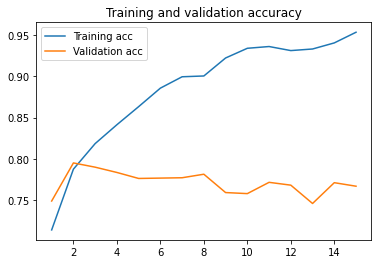

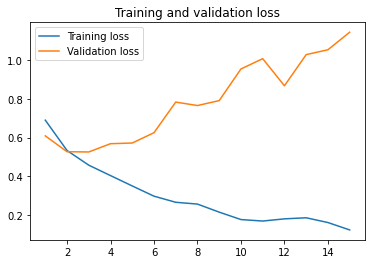

In [33]:
import matplotlib.pyplot as plt

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model.save("bilstmCNNAtt.h5")

In [38]:
from modelutility import predictionFunction
predictionFunction(X_test,dataCopy,model,labels = ['positive', 'negative', 'neutral'])

#Model evaluation

Confusion matrix: 
[[ 287   89   83]
 [  52 1688  149]
 [  50  203  327]]
Prediction Accuracy: 
Accuracy of Positive class in % : 
62.527233115468405
Accuracy of Negative class in %: 
89.35944944415034
Accuracy of Neutral class in %
56.37931034482758


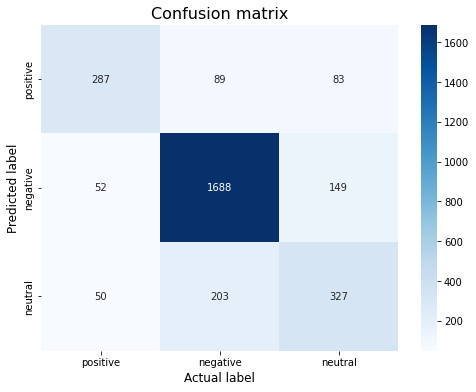

In [37]:
from modelutility import confusionMatrix
confusionMatrix(model, X_test, y_test)

In [ ]:
dataCopy.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64